# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** first name and last name  
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [50]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from scipy import ndimage
import cv2 as cv

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

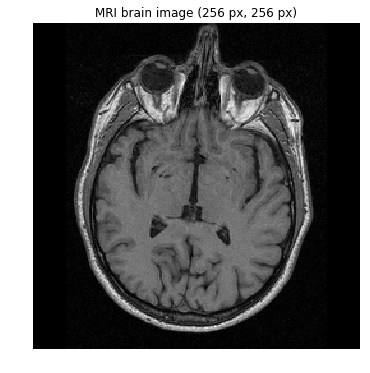

In [52]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Add your implementation and discussion

In [53]:
def region_growing(img,i=100,j=100):
    """  
    Implementation of region growing method     
    Parameters: 
    img (numpy array): Source image
    i,j (int,int): Coordinates of the starting point which are entered manually by the user
    Returns: 
    Segmented Image
    """
    neighbors = [(0,1),(0,-1),(-1,0),(1,0)]
    intensity_thresh = 20
    width = img.shape[0]
    height = img.shape[1]    
    visited = []
    bfs_pixels = []
    seg = np.zeros((img.shape[0],img.shape[1]))
    if (i,j) in visited:
        return
    
    reg_els = 1
    reg_sum = img[i,j]
    bfs_pixels.append((i,j))

    while len(bfs_pixels) > 0:

        
        cur = bfs_pixels.pop(0)
        
        
        #print('cur is: ',cur[0],cur[1]) 
        if cur[0] < 0 or cur[0] >=height or cur[1]<0 or cur[1] >= width:
            continue
            
        if cur in visited or abs(img[cur[0],cur[1]] - reg_sum/reg_els) > intensity_thresh:
            #Intensity of the region should be within some thresh from the average intensity of the neighbors
            continue

        reg_els = reg_els + 1
        reg_sum = reg_sum + img[cur[0],cur[1]]
        seg[cur[0],cur[1]] = 255
        visited.append(cur)
        for nb in neighbors:
            bfs_pixels.append((cur[0]+nb[0],cur[1]+nb[1]))
    
    return seg

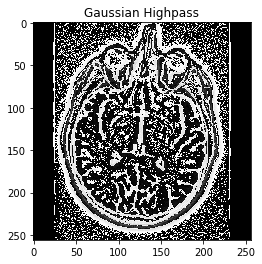

In [54]:
lowpass = ndimage.gaussian_filter(brain_im, 3)
gauss_highpass = brain_im - lowpass
#plot(ndimage.median_filter(gauss_highpass,15), r'Gaussian Highpass, $\sigma = 3 pixels$')
plot(gauss_highpass,'Gaussian Highpass')

In order to remove the 'salt and pepper' noise from the above image, we apply the median filter.

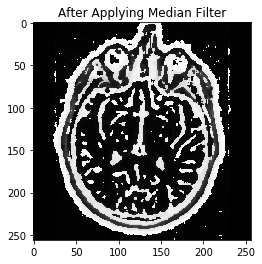

In [55]:
med_gauss_high = ndimage.median_filter(gauss_highpass,5)
plot(med_gauss_high,'After Applying Median Filter')

After applying the filters, it is much more clearer which part of the image consists the brain. We can also see that the brain is separated from the skull by a thick grey layers, so if we do region growing now, it will be able to segment the brain.

In [56]:
seg_img1 = region_growing(med_gauss_high)

/home/emiljano/anaconda3/envs/programming/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in ubyte_scalars


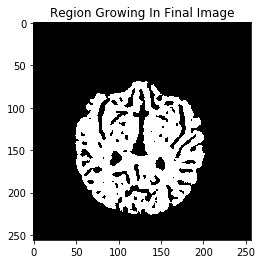

In [57]:
plot(seg_img1,'Region Growing In Final Image')

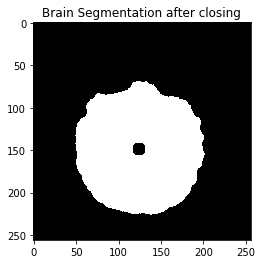

In [58]:
kern = cv.getStructuringElement(cv.MORPH_ELLIPSE,(15,15))
brain_close = cv.morphologyEx(seg_img1,cv.MORPH_CLOSE,kern)
plot(brain_close,'Brain Segmentation after closing')

### 1.3 Contour detection
Add your implementation and discussion

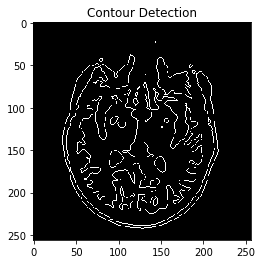

In [62]:
blur = cv.blur(brain_im, (5,5)) # blur the image
ret, thresh = cv.threshold(blur, 70, 200, cv.THRESH_BINARY)
im2, contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

drawing = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8)
 
for i in range(len(contours)):
    color_contours = (255, 255, 255) 
    
    cv.drawContours(drawing, contours, i, color_contours, 1, 8, hierarchy)

plot(drawing,'Contour Detection')

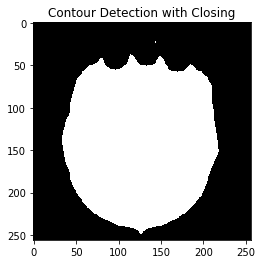

In [64]:
kern = cv.getStructuringElement(cv.MORPH_ELLIPSE,(29,29))
close = cv.morphologyEx(drawing,cv.MORPH_CLOSE,kern)
plot(close,'Contour Detection with Closing')

### 1.4 Additional method(s)
Add your implementation and discussion

In [65]:
def plot(data, title):
    """  
    Plotting Utility Function
    """
    plt.imshow(data)
    plt.gray()
    plt.title(title)

## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

### 2.2 Count the number of Varroa on each picture

Add your implementation and discussion

Hint: `skimage.measure.label` might be useful to label the thresholded image

Here, we visualize the 4 images for our patern detection

In [66]:
test_im = skimage.io.imread(os.path.join(data_path,'varroa-01.jpg'))

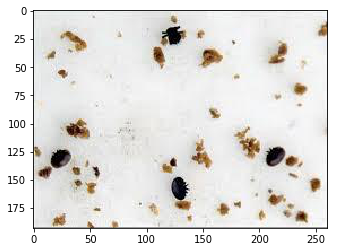

In [67]:
plt.imshow(test_im)

Before looking at the histogram, we apply the histogram normalization in order to increase the contrast and better determine the threshold

(array([ 496.,   98.,   84.,   73.,   73.,   70.,   58.,  107.,   65.,
          67.,   54.,   56.,   60.,   43.,   54.,   49.,   52.,   53.,
          40.,   53.,   43.,   42.,   41.,   33.,   48.,   33.,   39.,
          38.,   30.,   42.,   36.,   34.,   35.,   38.,   49.,   40.,
          42.,   37.,   45.,   33.,   44.,   43.,   39.,   36.,   42.,
          47.,   38.,   49.,   39.,   44.,   40.,   42.,   62.,   44.,
          47.,   41.,   46.,   29.,   63.,   52.,   52.,   40.,   53.,
          47.,   50.,   42.,   52.,   60.,   57.,   60.,   64.,   50.,
          66.,   62.,   44.,   75.,   50.,   53.,   55.,   77.,   56.,
          55.,   70.,   56.,   67.,   64.,   81.,   64.,   61.,   77.,
          59.,   54.,   56.,   69.,   60.,   78.,   76.,   67.,   79.,
          76.,   79.,   74.,   77.,   64.,   75.,   72.,   64.,   62.,
          67.,   67.,   80.,   79.,   80.,   64.,   81.,   76.,   78.,
          70.,   91.,   77.,   93.,   69.,   84.,   81.,   96.,   61.,
      

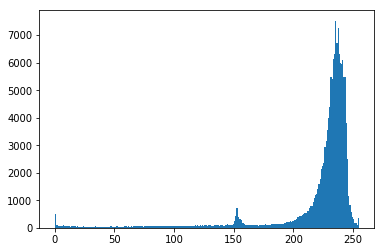

In [68]:
plt.hist(test_im.ravel(),256)

In [69]:
gauss_test = ndimage.gaussian_filter(test_im,3)

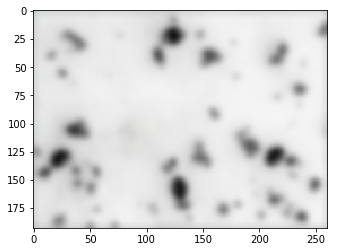

In [70]:
plt.imshow(gauss_test)

(array([5.000e+00, 9.000e+00, 1.200e+01, 9.000e+00, 1.600e+01, 6.000e+00,
        2.700e+01, 3.600e+01, 0.000e+00, 2.300e+01, 2.400e+01, 2.200e+01,
        3.300e+01, 2.800e+01, 3.000e+01, 3.400e+01, 0.000e+00, 1.700e+01,
        2.200e+01, 1.200e+01, 3.100e+01, 3.500e+01, 2.500e+01, 3.200e+01,
        0.000e+00, 2.100e+01, 1.800e+01, 2.400e+01, 2.700e+01, 1.900e+01,
        2.600e+01, 2.900e+01, 2.100e+01, 0.000e+00, 2.500e+01, 2.800e+01,
        1.700e+01, 1.700e+01, 2.600e+01, 1.700e+01, 1.600e+01, 0.000e+00,
        3.600e+01, 4.400e+01, 1.900e+01, 8.000e+00, 2.700e+01, 2.500e+01,
        1.500e+01, 0.000e+00, 3.300e+01, 4.100e+01, 3.100e+01, 2.700e+01,
        2.100e+01, 2.900e+01, 3.100e+01, 0.000e+00, 1.700e+01, 1.600e+01,
        2.800e+01, 3.700e+01, 2.800e+01, 4.600e+01, 3.700e+01, 3.300e+01,
        0.000e+00, 4.400e+01, 2.200e+01, 1.700e+01, 1.800e+01, 3.200e+01,
        3.600e+01, 2.600e+01, 0.000e+00, 1.800e+01, 3.700e+01, 3.700e+01,
        3.200e+01, 3.500e+01, 3.900e+0

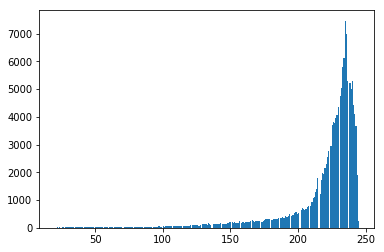

In [71]:
plt.hist(gauss_test.ravel(),256)

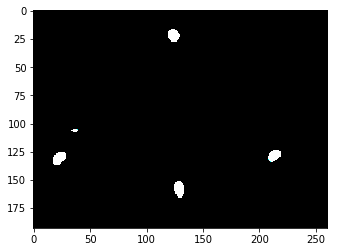

In [73]:
ret,thresh2 = cv.threshold(gauss_test,70,255,cv.THRESH_BINARY_INV)
plt.imshow(thresh2)

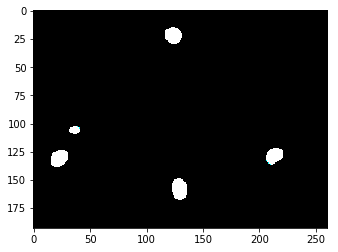

In [75]:
kern = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
dilation = cv.dilate(thresh2,kern,iterations = 1)
plt.imshow(dilation)

We can observe that in the case when two mites are very close to one another, they will be detected as a single one. Hence, apply erosion to separate them.

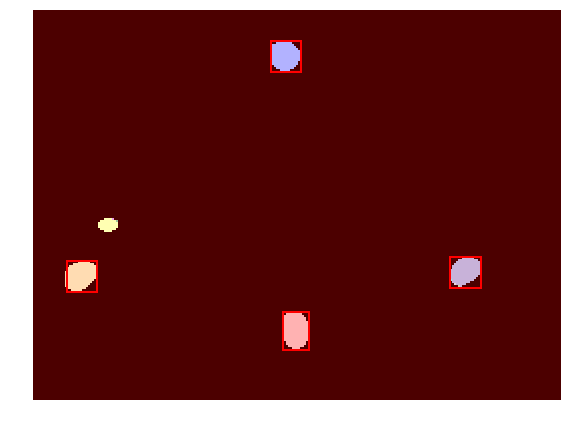

In [77]:
dil = cv.cvtColor(dilation, cv.COLOR_BGR2GRAY)
label_image = skimage.measure.label(dil)
image_label_overlay = label2rgb(label_image, image=dil)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 70 and region.area <= 800:
        # draw rectangle around thresholded regions
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [78]:
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

('Number of images: ', 4)


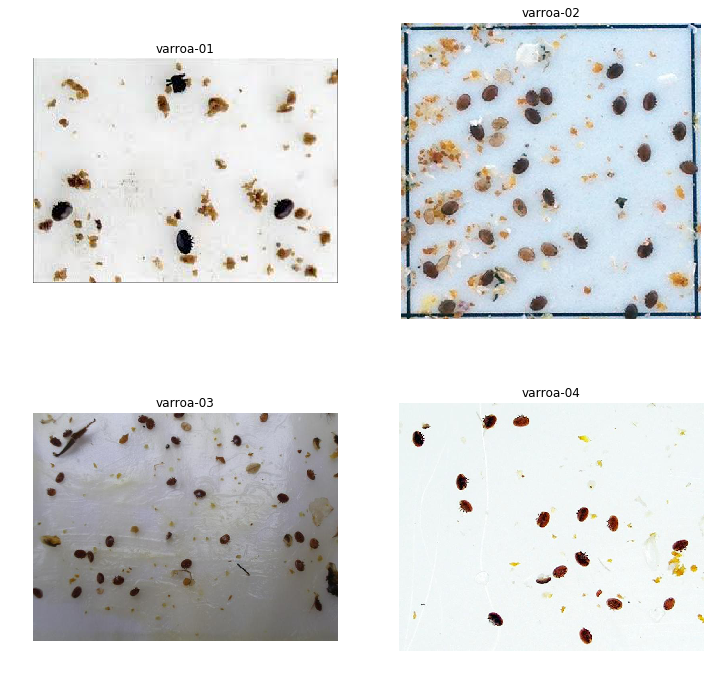

In [79]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [80]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects


In [81]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]

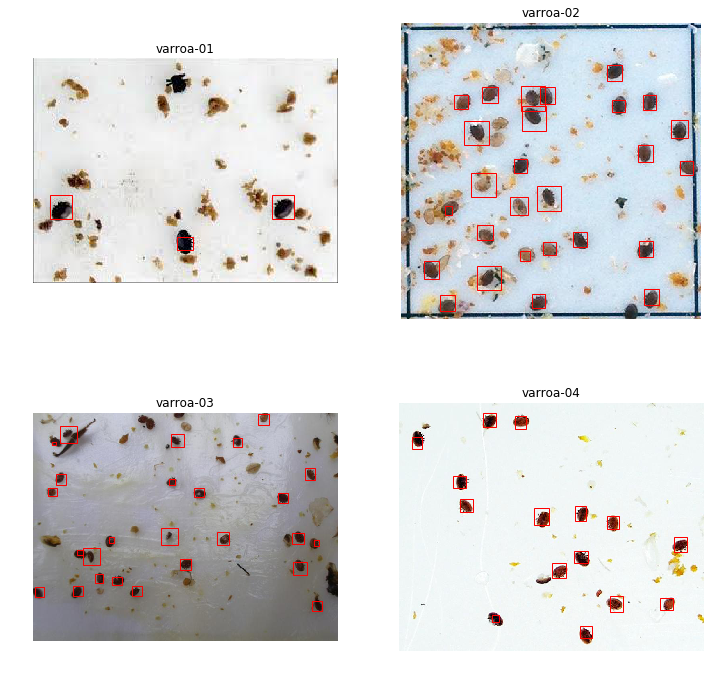

In [82]:

# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
       
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

In [83]:
varroas = []
for prop in regionprops(label_image):
        varroas.append(prop.bbox)

In [84]:
regions = []
for region in regionprops(label_image):
    if region.area >=70 and region.area <=800:
        regions.append(region)

In [85]:
annot = annotations_xmls[0]

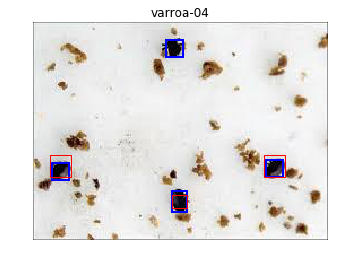

In [86]:
# Create figure and axes

im = test_im
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)


for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 70 and region.area <= 800:
        #print(region.area)
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='blue', linewidth=2)
        ax.add_patch(rect)




for anno in annot:
    rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
            linewidth=1,edgecolor='r',facecolor='none')

    ax.add_patch(rect)

    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)

plt.show()

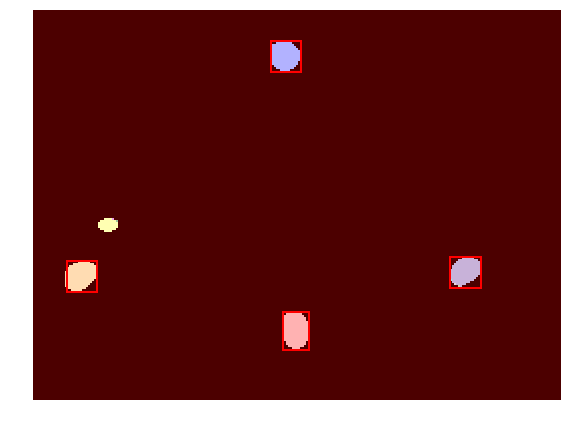

In [88]:
dil = cv.cvtColor(dilation, cv.COLOR_BGR2GRAY)
label_image = skimage.measure.label(dil)
image_label_overlay = label2rgb(label_image, image=dil)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 70 and region.area <= 800:
        #print(region.area)
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)



ax.set_axis_off()
plt.tight_layout()
plt.show()

### 2.3 IoU of the detected pattern w.r.t. the ground truth

Add your implementation and discussion

Hint: `skimage.measure.regionprops` implements a large variety of descriptors

# Idea: 

Find the pair of rectangles whose area of intersection is larger and then set the dimensions of our rectangle to the dimensions of the rectangle in the ground truth

In [89]:
def is_corner_inside(x,y,bbox):
    
    """
    Checks if a corner is inside bounding box
    Parameters: 
    x (int): x coordinate of the corner
    y (int): y coordinate of the corner
    bbox (tuple): bounding box
  
    Returns: 
    boolean: True if the corner is inside the bounding box or false otherwise
  
    """
    if x >=bbox[0] and x<bbox[2] and y>=bbox[1] and y<bbox[3]:
        return True
    return False

In [90]:
def bbox_to_corners(bbox):
    """  
    Convert bounding box coordinates from (xmin,ymin,width,height) to (xmin,ymin,xmax,ymax)  
    Parameters: 
    bbox (list): bounding box 
  
    Returns: 
    list: bounding box with coordinates (xmin,ymin,xmax,ymax)
  
    """
    return [bbox[0],bbox[1],bbox[0]+bbox[2],bbox[1]+bbox[3]]

In [91]:
def find_intersection(bboxA,bboxB):
    """  
    Find area of intersection of two bounding boxes
    Parameters: 
    bboxA (list): first bounding box
    bboxB (list): second bounding box
  
    Returns: 
    int: Area of intersection of bounding boxes
  
    """
    dif1 = min(bboxA[2],bboxB[2]) - max(bboxA[0],bboxB[0])
    dif2 = min(bboxA[3],bboxB[3]) - max(bboxA[1],bboxB[1])
    if dif1 <= 0 or dif2 <= 0:
        return 0
    else:
        return dif1*dif2

In [92]:
def find_union(bboxA,bboxB):
    """  
    Find area of union of two bounding boxes
    Parameters: 
    bboxA (list): first bounding box
    bboxB (list): second bounding box
  
    Returns: 
    int: Area of union of bounding boxes as sum of areas - area of intersection
  
    """
    area1 = (bboxA[2]-bboxA[0])*(bboxA[3] - bboxA[1])  
    area2 = (bboxB[2]-bboxB[0])*(bboxB[3] - bboxB[1]) 
    return area1 + area2  - find_intersection(bboxA,bboxB)

In [ ]:
def area_dif(bboxA,bboxB):
    """  
    Returns the difference in areas between two bounding boxes
    
    Parameters: 
    bboxA (list): first bounding box
    bboxB (list): second bounding box
  
    Returns: 
    int: difference in areas between the two bounding boxes
  
    """
    area1 = (bboxA[2] - bboxA[0]) * (bboxA[3] - bboxA[1])
    area2 = (bboxB[2] - bboxB[0]) * (bboxB[3] - bboxB[1])
    return area2 - area1

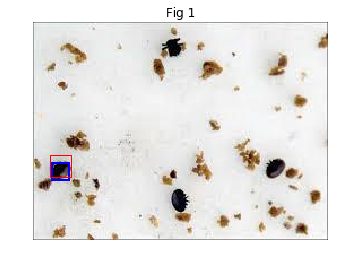

In [93]:
# Create figure and axes

im = test_im
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

regions = regionprops(label_image)
region = regions[5]

if region.area >= 70 and region.area <= 800:
    #print(region.area)
    # draw rectangle around segmented coins
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='blue', linewidth=2)
    ax.add_patch(rect)

anno = annot[0]
rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
        linewidth=1,edgecolor='r',facecolor='none')

ax.add_patch(rect)

ax.imshow(im)
ax.axis('off')
ax.set_title('Fig 1')

plt.show()

In [94]:
print(region.bbox)
print(anno['bbox'])
print(find_intersection(region.bbox,anno['bbox']))

(124L, 16L, 139L, 31L)
[14, 117, 19, 20]
0


In the figure above, there is clearly overlap between the two rectangles. However the find_intersection method returns 0. As we can see, it appears to be a mismatch in coordinate labeling between the output of the regionprops method and the coordinates that we read from the XML file. In the regionprops output, 0 and 2 correspond to minY and maxY, while in the coordinates that we read from the XML file 0 and 2 correspond to minX and maxX. Hence, we fix the mismatch in the cell below

In [95]:
# Fix the mismatch between the coordinate labeling
regions_tmp = regionprops(label_image)
regions = []
for r in regions_tmp:
    if r.area >= 70 and r.area<=800:
        reg = list(r.bbox)
        tmp = reg[0]
        reg[0] = reg[1]
        reg[1] = tmp
        tmp = reg[2]
        reg[2] = reg[3]
        reg[3] = tmp
        regions.append(reg)
regions

[[117L, 15L, 132L, 30L],
 [206L, 122L, 221L, 137L],
 [16L, 124L, 31L, 139L],
 [123L, 149L, 136L, 168L]]

In [96]:
anot1 = annotations_xmls[0]
ground_truth = []
for i in range(len(anot1)):
    ground_truth.append(anot1[i]['bbox'])


for i in range(len(ground_truth)):
    ground_truth[i] = bbox_to_corners(ground_truth[i])

In [97]:
pair_matching = []
intersections = []
for region in regions:
    max_intersection = 0
    best_match_index = -1
    for j in range(len(ground_truth)):
        intersection = find_intersection(region,ground_truth[j])
        if intersection > 0:
            print('intersection: ', intersection)
        if intersection > max_intersection:
            best_match_index = j
            max_intersection = intersection

    intersections.append(max_intersection)
    pair_matching.append([region,ground_truth[best_match_index]])

('intersection: ', 225L)
('intersection: ', 195L)
('intersection: ', 143L)


In [98]:
pair_matching

[[[117L, 15L, 132L, 30L], [123, 153, 136, 164]],
 [[206L, 122L, 221L, 137L], [204, 117, 223, 137]],
 [[16L, 124L, 31L, 139L], [14, 117, 33, 137]],
 [[123L, 149L, 136L, 168L], [123, 153, 136, 164]]]

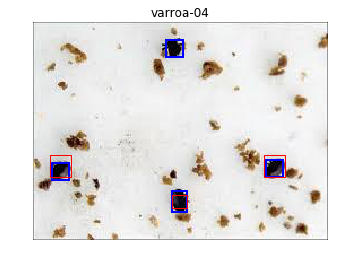

In [99]:
# Create figure and axes

im = test_im
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)


for region in regions:
    
    minr, minc, maxr, maxc = region
    rect = mpatches.Rectangle((minr, minc), maxr - minr, maxc - minc,
                              fill=False, edgecolor='blue', linewidth=2)
    ax.add_patch(rect)


for anno in annot:
    rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
            linewidth=1,edgecolor='r',facecolor='none')

    ax.add_patch(rect)

    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)

plt.show()

In [100]:
pair_matching

[[[117L, 15L, 132L, 30L], [123, 153, 136, 164]],
 [[206L, 122L, 221L, 137L], [204, 117, 223, 137]],
 [[16L, 124L, 31L, 139L], [14, 117, 33, 137]],
 [[123L, 149L, 136L, 168L], [123, 153, 136, 164]]]

In [101]:
# Calculate ratios of area of intersection/area_of union
ratios = []
for p in pair_matching:
    ratios.append(float(find_intersection(p[0],p[1]))/find_union(p[0],p[1]))
print(ratios)

[0.0, 0.5921052631578947, 0.47560975609756095, 0.5789473684210527]


### 2.4 Precision, Recall and F1-score at two different IoU thresholds

Add your implementation and discussion

In [106]:
#Calculate precision and recall
thresholds = [0.5,0.9]
for thresh in thresholds:
    fp,fn,tp,prec,recall,f1 = [0.,0.,0.,0.,0.,0.]
    for r in ratios:
        if r == 0:
            fp +=1
        if r>0 and r< thresh:
            fn +=1
        elif r>=thresh:
            tp +=1
    prec = tp/(tp+fp)
    recall = tp/(tp+fn)
    if prec+recall > 0:
        f1 = 2*prec*recall/(prec+recall)
    print('precision for threshold = {0} is {1}'.format(thresh,prec))
    print('recall for threshold = {0} is {1}'.format(thresh,recall))
    print('f1-score for threshold = {0} is {1}'.format(thresh,f1))

precision for threshold = 0.5 is 0.666666666667
recall for threshold = 0.5 is 0.666666666667
f1-score for threshold = 0.5 is 0.666666666667
precision for threshold = 0.9 is 0.0
recall for threshold = 0.9 is 0.0
f1-score for threshold = 0.9 is 0.0
